In [1]:
import os
import time
import json
import utils
import parse
import fasttext
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt



In [2]:
columns = ["suitable"] + [f"run_{i}" for i in range(15)]
df = pd.read_csv("backup_25.csv").loc[:, columns]
y_true, y_pred = [], []

for i in range(15):
    y_true.extend(df.suitable.values.tolist())
    y_pred.extend(df[f"run_{i}"].values.tolist())


microF1=0.9163
macroF1=0.7159


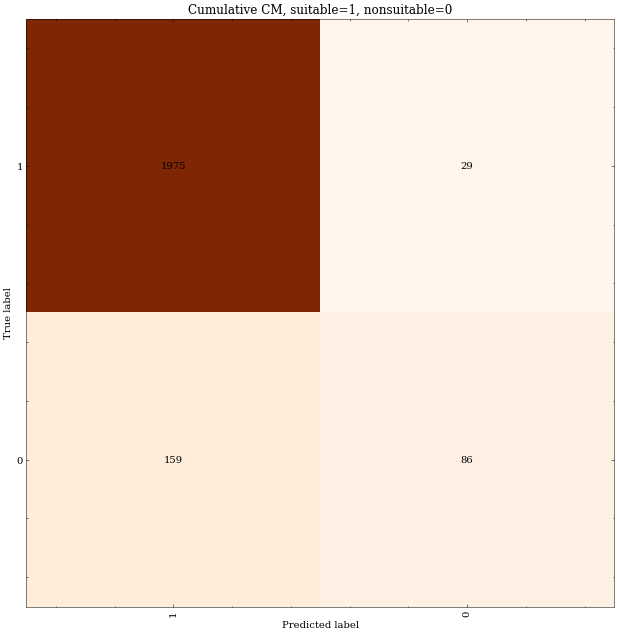

(0.9162962962962963, 0.7159204969199487)

In [5]:
utils.plot_cm(y_true, y_pred, labels=[1,0], title="Cumulative CM, suitable=1, nonsuitable=0", 
save="images/25_cumulative_CM.png", include_metrics=False)

In [21]:
f1s = list()
for i in range(15):
    from sklearn.metrics import f1_score
    from sklearn.dummy import DummyClassifier
    y_true = df.suitable.values
    y_pred = df[f"run_{i}"].values
    f1s.append(f1_score(y_true, y_pred))

In [22]:
np.mean(f1s), np.std(f1s)

(0.9544980538407455, 0.002851664406272193)

In [24]:
dummy_f1s = list()
for i in range(15):
    from sklearn.metrics import f1_score
    from sklearn.dummy import DummyClassifier
    y_true = df.suitable.values
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(y_true, y_true)
    y_pred = dummy_clf.predict(y_true)
    dummy_f1s.append(f1_score(y_true, y_pred))
print(f"Dummy clf: strategy: 'stratified', {np.mean(dummy_f1s):0.3} +/- {np.std(dummy_f1s):0.3}")
p = stats.mannwhitneyu(f1s, dummy_f1s, alternative='greater')[1]
print(f"\t p_value: {p:0.3}")
dummy_f1s = list()
for i in range(15):
    from sklearn.metrics import f1_score
    from sklearn.dummy import DummyClassifier
    y_true = df.suitable.values
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(y_true, y_true)
    y_pred = dummy_clf.predict(y_true)
    dummy_f1s.append(f1_score(y_true, y_pred))
print(f"Dummy clf: strategy: 'most_frequent', {np.mean(dummy_f1s):0.3} +/- {np.std(dummy_f1s):0.3}")
p = stats.mannwhitneyu(f1s, dummy_f1s, alternative='greater')[1]
print(f"\t p_value: {p:0.3}")

Dummy clf: strategy: 'stratified', 0.894 +/- 0.00945
	 p_value: 1.69e-06
Dummy clf: strategy: 'most_frequent', 0.942 +/- 0.0
	 p_value: 3.41e-07
